# Fintech Python 数据采集、处理、分析以及机器学习

## 预备知识

1. python3.0以上基础 [https://www.python.org](https://www.python.org)
2. python http访问库，[requests](http://www.python-requests.org/en/master/)
3. python html解析库，[Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/)
4. python 数据处理库，[Pandas](https://pandas.pydata.org)
5. python 绘图工具库，[Matplotlib](https://matplotlib.org)
6. machine learning， [Tensorflow](https://www.tensorflow.org)
7. web&http基本概念和原理  

以上的工具库或者开源项目，大家在学习的时候，其实只需要关注其基本概念和原理以及官方文档的前几章，在后面的课程中我们会一步一步边上课边讲解。

## 课程题目简介
通过本课程，我们将去探索人民币汇率和国内油价是否存在某种关系。    
同时用机器学习的方法去给这种关系建立模型，并通过这个模型给出一个汇率，从而简单预测国内油价。    
该课程建立的模型仅仅是为了介绍方法，大家也知道强扭的瓜不甜，这个模型或许就是错误的，重要的是获取这个结果，我们使用了什么样的方法。

## web和http基本概念
web - World Wide Web，万维网    
http - hyper text transfer protocol 超文本传输协议    
**计算机连接  ->  所有设备的连接  ->  人的连接**

## 数据采集
这部分我们将探索如何使用python这门语言以及其提供的开源项目去抓取目标数据。    
主要分为两个部分： 
* 人民币汇率数据的抓取  
* 国内油价数据的抓取

### 人民币汇率数据的抓取
数据来源，中国银行外汇牌价 [中国银行](http://www.boc.cn/sourcedb/whpj/)

#### 汇率数据的网页结构分析
该页面提供了一个根据起始时间和结束时间以及外币币种的搜索操作，我们根据此操作获取2012-1-1至2018-10-1之间的人民币和美元的汇率数据。    
本课程选择 *现钞卖出价* 作为目标数据。 
经过分析可以得出实际的获取url为: http://srh.bankofchina.com/search/whpj/search.jsp?erectDate=2018-10-01%2020:00:00&nothing=2018-10-02%2021:00:00&pjname=1316    
其中erectDate为开始时间，nothing为结束时间，pjname为外汇类型(1316为美元)。
开始时间和结束时间虽然在界面上通过ui操作只能生成日为单位的时间，但是经过尝试，发现可以接受带时分秒的参数。在上述的url中带了时分秒，其中%20是经过url编码的空格。    
如果起始时间设置为2012-01-01，结束时间设置为2018010-01，则search结果为一个分页的数据列表，大概每天的数据为3页，而我们的目标是每天一个汇率数据即可，我们选择每天00:00:00-23:59:59之间的第一条数据作为当日数据。    

**那接下来我们是分页去获取数据，还是采用别的方式呢？大家这里可以思考一下。**


#### 汇率数据的抓取
基于上一节的分析，我们准备每次抓取数据都构建如下的http请求:    
- url:  http://srh.bankofchina.com/search/whpj/search.jsp
- method: GET
- query string:   
   - erectDate 起始时间 2018-10-01 09:00:00
   - nothing   结束时间 2018-10-01 10:00:00
   - pjname    1316
- user agent: 随机列表选择

每次获取返回列表的第一条数据作为当日数据。

#### 汇率数据的提取和清洗
汇率数据我们抓取之后存储为csv格式：    
`day,price`    
每一行存储一个数据，分别是日期、汇率价格。    

#### 代码:

In [29]:
# import requests
# import random
# import datetime
# from bs4 import BeautifulSoup

# user_agents = [
#     'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
#     'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
#     'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/11.1.2 Safari/605.1.15',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/11.1 Safari/605.1.15',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2) AppleWebKit/604.4.7 (KHTML, like Gecko) Version/11.0.2 Safari/604.4.7',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/601.7.8 (KHTML, like Gecko) Version/9.1.3 Safari/601.7.8',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11) AppleWebKit/601.1.56 (KHTML, like Gecko) Version/9.0 Safari/601.1.56'
# ]

# def get_user_agent():
#     i = random.randint(0, 9)
#     return user_agents[i]

# start_day = datetime.date(2012, 1, 1)
# end_day = datetime.date(2018, 10, 1)

# with open('exchange_rate.csv', 'w') as f:
#     f.write('day,price\n')
#     for i in range((end_day-start_day).days+1):
#         day = start_day + datetime.timedelta(days=i)
#         erectdate = '{} 00:00:00'.format(day)
#         nothing = '{} 23:59:59'.format(day)
#         params = {'erectDate': erectdate, 'nothing': nothing, 'pjname':1316}
#         headers = {'user-agent': get_user_agent()}
#         r = requests.get('http://srh.bankofchina.com/search/whpj/search.jsp', params=params, headers=headers)

#         soup = BeautifulSoup(r.text, 'lxml')
#         try:
#             trs = soup.find(attrs={'class': 'BOC_main publish'}).find_all('tr')
#             price = trs[1].find_all('td')[4].text
#         except Exception as err:
#             continue 
#         line = '{},{}\n'.format(day, price)
#         f.write(line)
# print('done')

### 国内油价数据的抓取
数据来源，[四川汽油价格](https://www.cngold.org/crude/sichuan.html)

#### 油价数据的网页结构分析
该页面提供了一个四川价格的历史数据表格。        
油价以95号汽油价格为抓取对象。

#### 油价数据的抓取
基于上一节的分析，我们准备每次抓取数据都构建如下的http请求:
- url:  https://www.cngold.org/crude/sichuan.html
- method: GET
- query string: 无
- user agent: 随机列表选择

#### 油价数据的提取和清洗
汇率数据我们抓取之后存储为csv格式：    
`day,price`    
每一行存储一个数据，分别是日期、95号汽油价格。    

#### 代码：

In [30]:
# import requests
# import random
# from bs4 import BeautifulSoup

# user_agents = [
#     'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
#     'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
#     'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/11.1.2 Safari/605.1.15',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/11.1 Safari/605.1.15',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2) AppleWebKit/604.4.7 (KHTML, like Gecko) Version/11.0.2 Safari/604.4.7',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/601.7.8 (KHTML, like Gecko) Version/9.1.3 Safari/601.7.8',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11) AppleWebKit/601.1.56 (KHTML, like Gecko) Version/9.0 Safari/601.1.56'
# ]

# def get_user_agent():
#     i = random.randint(0, 9)
#     return user_agents[i]

# headers = {'user-agent': get_user_agent()}
# r = requests.get('https://www.cngold.org/crude/sichuan.html', headers=headers)
# r.encoding = 'utf-8'

# soup = BeautifulSoup(r.text, 'lxml')
# trs = soup.find(id='oilTable').find_all('tr')
# with open('oil_price.csv', 'w') as f:
#     f.write('day,price\n')
#     for tr in trs[2:]:
#         tds = tr.find_all('td')
#         day = tds[0].text.strip().replace('年','-').replace('月', '-').replace('日', '')
#         price = tds[5].text.strip()
#         line = '{},{}\n'.format(day, price)
#         f.write(line)
# print('done')

## 数据处理
为了能够绘出各种图标和曲线，我们需要使用工具库对数据进行预处理，使其能被绘图库的函数所接受。

## 数据分析

### 我们应该画一个什么样的图形
我们的目标是想通过直观的图形表示来观察汇率和油价是否存在某种关联，所以绘制一个什么样的图形也很重要。    
比如图形的横坐标和纵坐标分辨是什么？这是需要大家思考和定义的。    
在这里我们首先画两个最直观的曲线图，就是汇率和油价随着时间的变化。
接着我们画出汇率和油价的增幅随着时间的变化。

### 我们需要准备你想绘制图形的数据
在明确了你需要绘制的图形的各个输入变量，你得把你获取的数据重新整理和加工成符合条件的输入。    
为了不对目标网站造成流量增加的问题，我们直接利用之前抓取并保存的数据来进行后续的工作。我们需要从csv文件中读取数据，并作一定的处理：
- 对于汇率数据，如果某一天的数据有缺失，则使用前一天的数据进行填充。
- 对于油价数据，由于抓取的数据给出的日期是离散的，我们采取如下的策略来填充数据：如果8月1日油价为7.03元，8月20日油价变为7.45元，则认为8月2日-8月19日期间油价为7.03元。
- 计算变化率，其中变化率的定义为： *(当天值-昨天值)/昨天值*

### 时间序列曲线图 价格随时间变化
用pandas读取csv数据，在这一个小节的绘图中，我们没有对缺失的时间做任何填充。

In [31]:
import pandas as pd

exchange_data = pd.read_csv('exchange_rate.csv')
print(exchange_data)

oil_data = pd.read_csv('oil_price.csv')
print(oil_data)
oil_data = oil_data.sort_values(by='day', ascending=True)
print(oil_data)

             day   price
0     2012-01-01  629.93
1     2012-01-02  629.93
2     2012-01-03  629.93
3     2012-01-04  630.53
4     2012-01-05  631.31
5     2012-01-06  631.74
6     2012-01-07  631.74
7     2012-01-08  631.74
8     2012-01-09  632.44
9     2012-01-10  632.34
10    2012-01-11  632.84
11    2012-01-12  632.94
12    2012-01-13  631.63
13    2012-01-14  631.63
14    2012-01-15  631.63
15    2012-01-16  632.34
16    2012-01-17  632.29
17    2012-01-18  632.34
18    2012-01-19  632.74
19    2012-01-20  634.04
20    2012-01-21  633.14
21    2012-01-22  633.14
22    2012-01-23  633.14
23    2012-01-24  633.14
24    2012-01-25  633.14
25    2012-01-26  633.14
26    2012-01-27  633.14
27    2012-01-28  633.14
28    2012-01-29  632.34
29    2012-01-30  634.14
...          ...     ...
2431  2018-09-02  684.71
2432  2018-09-03  683.95
2433  2018-09-04  686.06
2434  2018-09-05  684.61
2435  2018-09-06  685.01
2436  2018-09-07  685.96
2437  2018-09-08  685.96
2438  2018-09-09  685.96


随着时间变化的汇率和油价曲线图

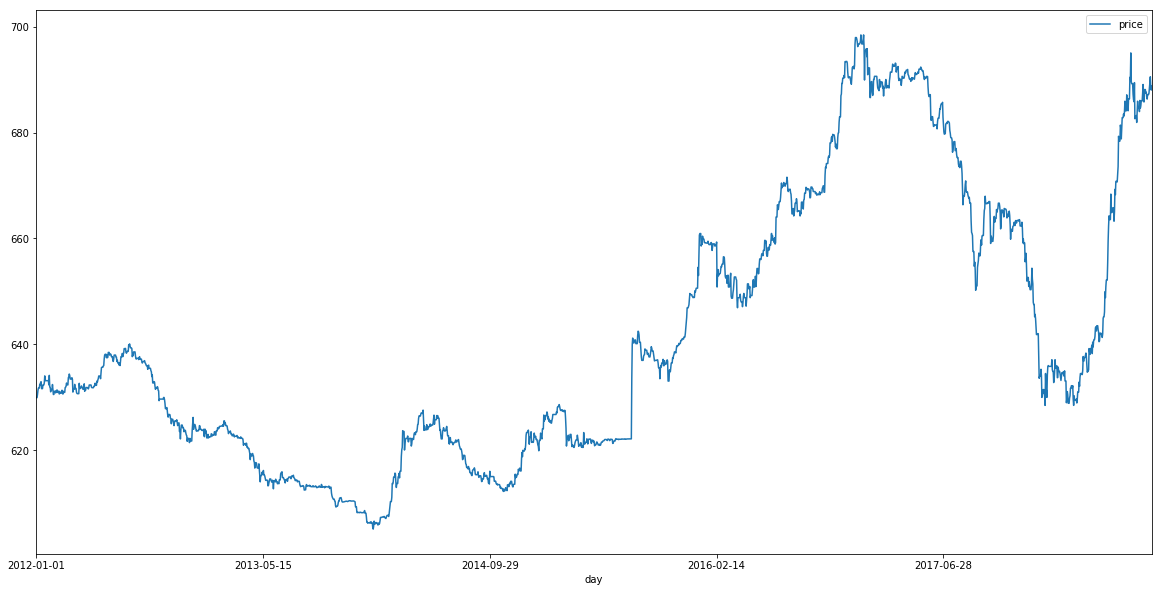

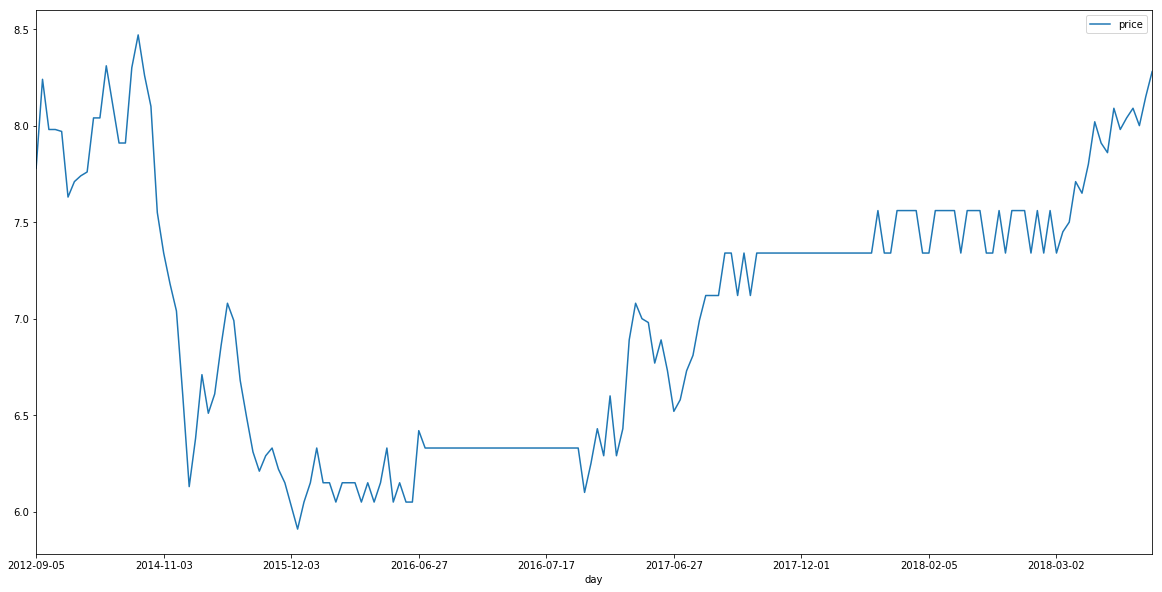

In [32]:
import matplotlib.pylab as plt
import pylab
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

exchange_data.plot('day', 'price')
oil_data.plot('day', 'price')
plt.show()

### 时间序列曲线图 涨幅随时间变化
在上一节中我们描绘出了汇率价格、油价随着时间变化的曲线图。    
我们需要用不同类型的图形或曲线来探索同样的问题，因此我们再来看看汇率价格波动、油价价格波动随着时间变化的曲线图。  
首先，我们需要对现有的数据中缺失的日期进行数据填充。

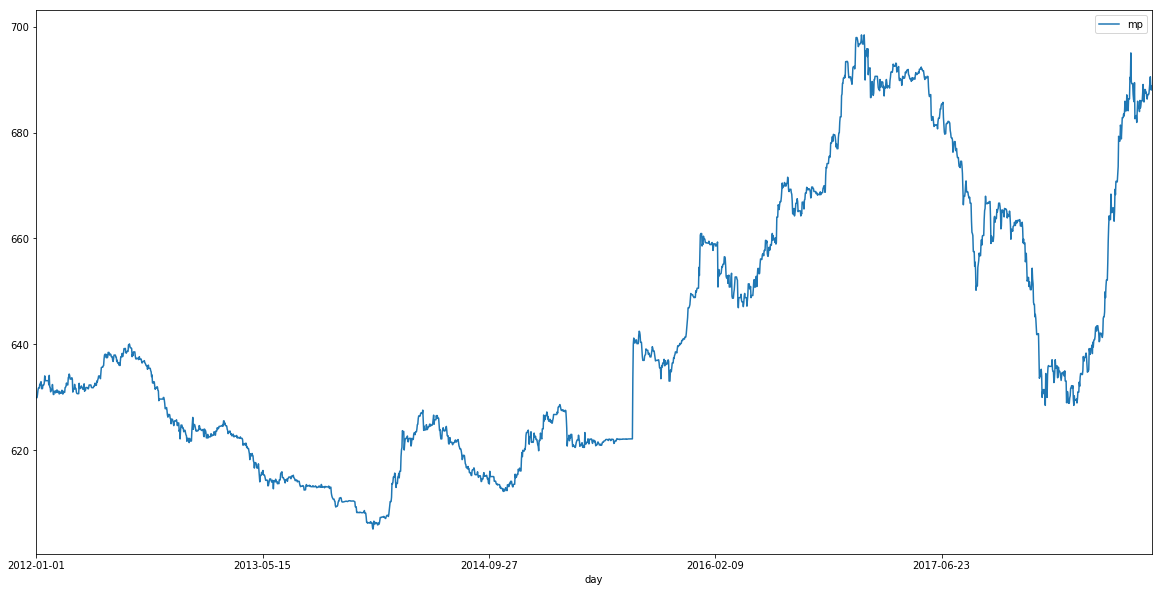

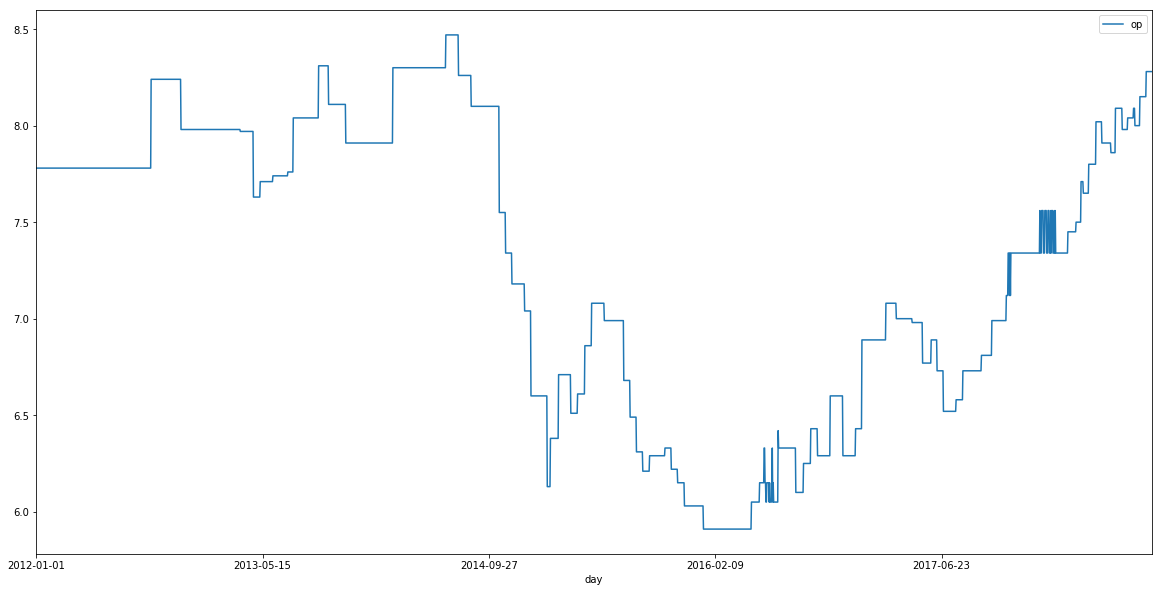

In [33]:
import datetime

start_day = datetime.date(2012, 1, 1)
end_day = datetime.date(2018, 10, 1)

# key:day value:price
mdict = {}
for rec in exchange_data.values:
    mdict[rec[0]] = rec[1]    
odict = {}
for rec in oil_data.values:
    odict[rec[0]] = rec[1]

# day,money_price,oil_price,money_price_change,oil_price_change
data = []
last_mp = 629.93
last_op = 7.78
for i in range((end_day-start_day).days+1):
    day = start_day + datetime.timedelta(days=i)
    
    mp = mdict.get(str(day))
    if mp == None:
        mp = last_mp
    mpc = (mp-last_mp)/last_mp
    last_mp = mp
    
    op = odict.get(str(day))
    if op == None:
        op = last_op
    opc = (op-last_op)/last_op
    last_op = op
    
    row = {'day': str(day), 'mp': mp, 'op': op, 'mpc': mpc, 'opc': opc}
    data.append(row)
    
df = pd.DataFrame(data)
df.plot('day', 'mp')
df.plot('day', 'op')
plt.show()

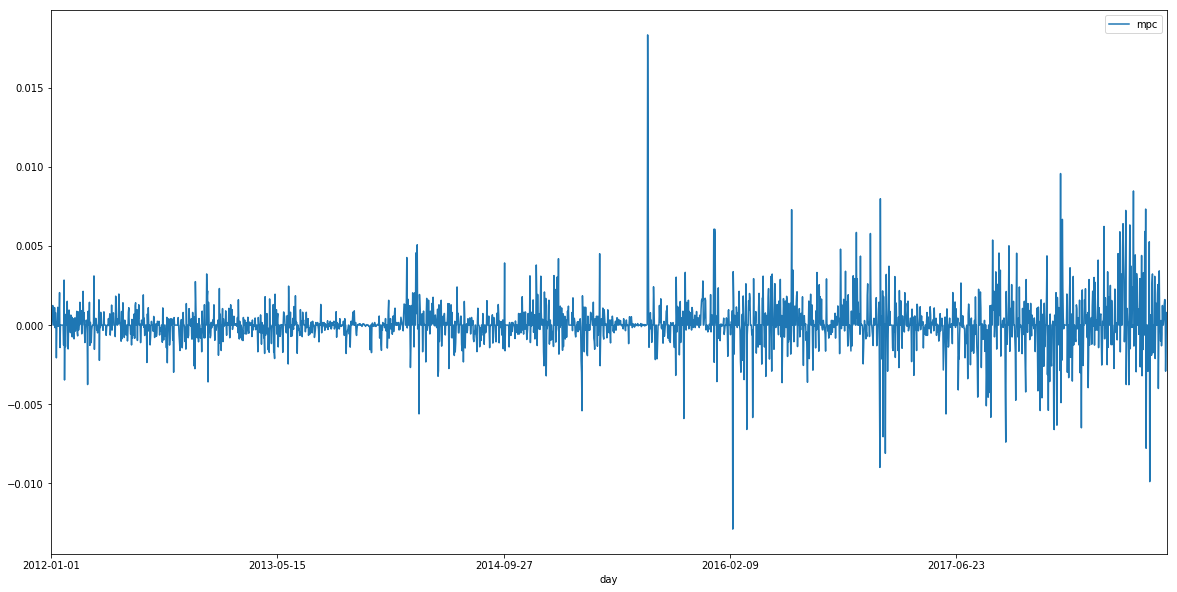

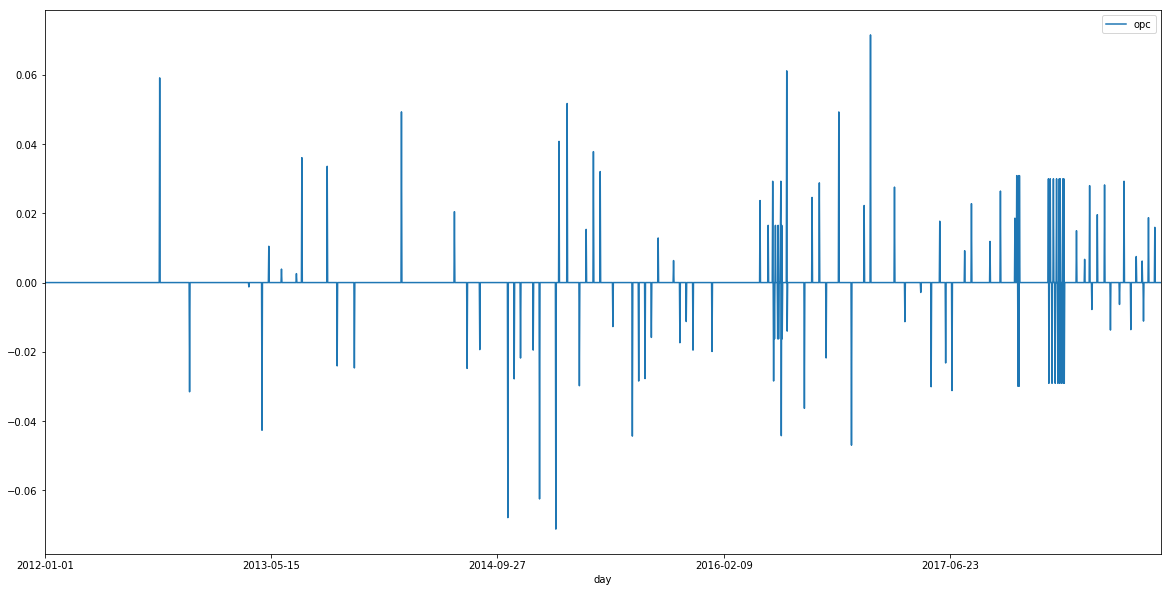

In [34]:
df.plot('day', 'mpc')
df.plot('day', 'opc')
plt.show()

## 机器学习

### 学习样本和测试样本的准备
需要对数据进行目标输出的标定，也就是对输出值进行定义。    
我们将油价从6.00-9.00这个区间，以0.20为一个步长，分割成15个等级，分别设置为对应的等级数字，学习模型的输出就是对预测值分布在这15个等级的打分。    
输入定义：汇率日期、汇率价格、汇率的波动值，一个1x3的向量。   
数据分割：我们把2012-01-01至2018-10-01的数据分割为两部分，使用2：1的比例分配。训练数据占2/3，测试数据占1/3。

#### 输出结果定义
定义油价的区间。    
我们将油价从6.00-9.00这个区间，以0.20为一个步长，分割成15个等级，分别设置为对应的等级数字，从0-14。在下面的代码中，0-14对应数组的索引值。

In [35]:
import numpy as np

# define price range
# 0|6.0-6.2 1|6.2-6.4 2|6.4-6.6 ...
oil_price_range = []
for x in np.arange(6.0, 9.0, 0.2):
    oil_price_range.append('{:.2}-{:.2}'.format(x, x+0.2))
print(oil_price_range)

['6.0-6.2', '6.2-6.4', '6.4-6.6', '6.6-6.8', '6.8-7.0', '7.0-7.2', '7.2-7.4', '7.4-7.6', '7.6-7.8', '7.8-8.0', '8.0-8.2', '8.2-8.4', '8.4-8.6', '8.6-8.8', '8.8-9.0']


#### 训练和测试数据的准备
我们把2012-01-01至2018-10-01的数据分割为两部分，使用2：1的比例分配。训练数据占2/3，测试数据占1/3。

##### 按照2:1概率分配数据的函数
定义一个函数，用来确定给定的数据是进入训练数据集还是测试数据集，且分布几率为2：1。

In [36]:
import random

def go_to_training_set():
    i = random.randint(0, 2)
    return True if i < 2 else False

yes_count = 0
no_count = 0

# Adjust the value of the parameter to see what happens?
for x in range(0, 50):
    b = go_to_training_set()
    if b:
        yes_count += 1
    else:
        no_count += 1

print('yes_count:{} | no_count:{} | yes/no:{}'.format(yes_count, no_count, yes_count/no_count))
    

yes_count:35 | no_count:15 | yes/no:2.3333333333333335


##### 给出一个油价值，获取其所在区间的索引值

In [37]:
def get_lable_of_oil_price(price):
    return int((price-6.0)/0.2)

print(get_lable_of_oil_price(6.12))
print(get_lable_of_oil_price(6.20))
print(get_lable_of_oil_price(6.22))
print(get_lable_of_oil_price(8.88))


0
1
1
14


##### 训练数据和测试数据的准备
生成原始数据，并将原始数据映射到0-1区间

In [38]:
import datetime

start_day = datetime.date(2012, 1, 1)
end_day = datetime.date(2018, 10, 1)

# key:day value:price
mdict = {}
for rec in exchange_data.values:
    mdict[rec[0]] = rec[1]    
odict = {}
for rec in oil_data.values:
    odict[rec[0]] = rec[1]
    
# training data
train_data = []
train_labels = []
# test data
test_data = []
test_labels = []

last_mp = 629.93
last_op = 7.78
total_days = (end_day-start_day).days+1 
for i in range(total_days):
    day = start_day + datetime.timedelta(days=i)
    
    mp = mdict.get(str(day))
    if mp == None:
        mp = last_mp
    mpc = (mp-last_mp)/last_mp
    last_mp = mp
    
    op = odict.get(str(day))
    if op == None:
        op = last_op
    last_op = op
    
    i_day = i/total_days
    i_mp = mp/1000
    if go_to_training_set():
        train_data.append((i_day, i_mp, mpc))
        train_labels.append(get_lable_of_oil_price(op))
    else:
        test_data.append((i_day, i_mp, mpc))
        test_labels.append(get_lable_of_oil_price(op))
    

##### 将python原生列表转化为numpy矩阵

In [39]:
import numpy as np

np_train_data = np.array(train_data)
np_train_labels = np.array(train_labels)

np_test_data = np.array(test_data)
np_test_labels = np.array(test_labels)

print(np_train_data.shape)
print(np_train_labels.shape)


(1674, 3)
(1674,)


### 模型学习和训练

#### 设置神经网络
下面的代码设置了一个神经网络模型，用了2层。    
第一层构建了具有128个神经元的神经网络。    
第二层用于对输入数据做0-14的打分，以确定其属于不同区间的概率。    
其中：   
- relu用于隐层神经元输出
- softmax用于多分类神经网络的输出

总之你可以理解为模拟人脑思维和分析的过程，采用不同的方式不停的去辨析数据。

In [40]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(15, activation=tf.nn.softmax)
])

#### 生成神经网络
在上一节中我们设置了所使用的神经网络的初始化参数，我们现在用这些参数生成一个真正可用的神经网络。    
其中的参数你可以理解是为了保证神经网络用最靠谱的方式去分析数据所做的约束。

In [41]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### 训练这个模型

In [42]:
model.fit(np_train_data, np_train_labels, epochs=10)

Epoch 1/10
1674/1674 [==============================] - 0s 124us/step - loss: 2.6276 - acc: 0.1661
Epoch 2/10
1674/1674 [==============================] - 0s 30us/step - loss: 2.4621 - acc: 0.2378
Epoch 3/10
1674/1674 [==============================] - 0s 30us/step - loss: 2.3511 - acc: 0.2348
Epoch 4/10
1674/1674 [==============================] - 0s 30us/step - loss: 2.2703 - acc: 0.2342
Epoch 5/10
1674/1674 [==============================] - 0s 33us/step - loss: 2.2013 - acc: 0.2389
Epoch 6/10
1674/1674 [==============================] - 0s 31us/step - loss: 2.1505 - acc: 0.2628
Epoch 7/10
1674/1674 [==============================] - 0s 31us/step - loss: 2.1142 - acc: 0.2664
Epoch 8/10
1674/1674 [==============================] - 0s 28us/step - loss: 2.0856 - acc: 0.2903
Epoch 9/10
1674/1674 [==============================] - 0s 31us/step - loss: 2.0664 - acc: 0.2754
Epoch 10/10
1674/1674 [==============================] - 0s 29us/step - loss: 2.0479 - acc: 0.3154


### 模型校验
测试这个模型，评估准确性

In [43]:
test_loss, test_acc = model.evaluate(np_test_data, np_test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

792/792 [==============================] - 0s 95us/step
Test loss: 2.087087144755354
Test accuracy: 0.26641414141414144


### 模型的实践
我们来实际查看下模型的预测是否与已有的测试数据吻合

In [53]:
predictions = model.predict(np_test_data)

print(predictions[0])
print(np.argmax(predictions[0]))
print(np_test_labels[0])

print(predictions[100])
print(np.argmax(predictions[100]))
print(np_test_labels[100])

print(predictions[400])
print(np.argmax(predictions[400]))
print(np_test_labels[400])

print(predictions[500])
print(np.argmax(predictions[500]))
print(np_test_labels[500])

print(predictions[200])
print(np.argmax(predictions[200]))
print(np_test_labels[200])

acc_count = 0;
for i in range(0, len(predictions)):
    p = np.argmax(predictions[i])
    r = np_test_labels[i]
    if p == r:
        acc_count += 1;

print('acc percent: {}'.format(acc_count/len(predictions)))

[7.9289852e-03 7.3147709e-03 5.2170777e-03 3.7217929e-03 3.0266303e-03
 6.1370418e-03 1.0750392e-03 1.1879886e-03 5.5013561e-01 2.2517252e-01
 3.6379606e-02 1.4603117e-01 5.5976412e-03 5.1794108e-04 5.5615505e-04]
8
8
[0.01852435 0.01708213 0.01160926 0.00874339 0.00789468 0.01294789
 0.0029368  0.00291759 0.43153608 0.24916722 0.05720076 0.16952927
 0.00822209 0.00079298 0.00089554]
8
11
[0.12678275 0.10934164 0.07132033 0.06303539 0.08265924 0.06669801
 0.03975262 0.02596893 0.07039487 0.12030947 0.11072966 0.09915963
 0.01115895 0.00113726 0.00155125]
0
4
[0.15576294 0.13076748 0.08578802 0.07972956 0.11848944 0.07646605
 0.06193708 0.03479114 0.02747969 0.0665691  0.0956898  0.05683568
 0.00782439 0.00075498 0.00111469]
0
0
[0.04636563 0.04192019 0.027881   0.02228896 0.02294039 0.02909498
 0.00934426 0.00803567 0.2750372  0.23864941 0.08969343 0.17445579
 0.01169949 0.00117685 0.00141681]
8
10
acc percent: 0.26641414141414144


可以看出这个得出的acc的百分比和之前模型评估得出的正确率吻合。    
造成这个的原因是数据量过少，且95号油价的数据在2012年-2014年段有问题，造成数据训练的误差。当然也可能是我们不知道的一些因素造成的。    
在机器学习的工程实践中，调参很重要，主要是以下几个步骤的数据调整会影响训练效果：
1. 输入数据特征值的设定
2. 神经网络参数的设置

## 总结
通过本课程的学习，也只能让同学们大体的了解下可以运用python语言、相关的第三方大量成熟工具库和主流机器学习库能做什么事情。    
希望能够起到抛砖引玉的效果。    
科学是文明发展的基石，数学是科学的基础，语言是让科学传播的载体，希望大家好好学习，天天向上。    
谢谢！